## Imports

In [3]:
#from huggingface_hub import login
import os
import pandas as pd
from rich import print
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

pd.set_option('display.max_colwidth', None)

## Define variables

In [4]:
seed = 42 #reproducability  over training runs
clobber_project_dir = False #wipe the project director clean
project_dir = "chat_summarizer" #project name, also used as wandb project name

#creds
hf_token = os.environ["HF_TOKEN"]
wandb_key = os.environ["WANDB_KEY"]
hf_account_name = os.environ["HF_ACCOUNT_NAME"]

#HF touchpoints
hf_dataset_name = "knkarthick/dialogsum"
source_hf_model_name = "meta-llama/Llama-2-7b-hf"
destination_hf_model_name = f"{hf_account_name}/llama2-7b-dialogsum-qlora-gptq"
checkpoint_dir = "best_checkpoint"
quantization_dir = 'quantized'
merged_dir = 'merged_model'
project_path = os.path.join(project_dir, checkpoint_dir)
quant_path = os.path.join(project_dir, quantization_dir)

train_test_split_ratio = 0.1

#LoRA hparams
lora_r = 64  # rank
lora_alpha = lora_r * 2
lora_dropout = 0.05

#training hparams
epochs = 2
per_device_train_batch_size=8
gradient_accumulation_steps=4
early_stopping_patience = 3
learning_rate = 3e-4
logging_steps = 25
device = "cuda"
max_training_sample_length = 2048

In [5]:
print(project_dir)
!mkdir -p $project_dir
if clobber_project_dir:
    !rm -rf ./$project_dir

!ls -latrs ./$project_dir

chat_summarizer

total 0
0 drwxr-xr-x 1 root root 4096 Nov  5 04:48 runs
0 drwxr-xr-x 1 root root 4096 Nov  5 10:18 checkpoint-500
0 drwxr-xr-x 1 root root 4096 Nov  5 12:28 best_checkpoint
0 drwxr-xr-x 1 root root 4096 Nov  5 17:35 .
0 drwxr-xr-x 1 root root 4096 Nov  5 17:35 quantized
0 drwxr-xr-x 1 root root 4096 Nov  6 00:57 ..


## Initiate wandb

In [6]:
import wandb

#wandb.login(key = wandb_key)
#run = wandb.init(project=project_dir, job_type="training", anonymous="allow")

## Process data for training

In [7]:
def generate(text, model, temp=0.7,max_new_tokens = 24):
    from transformers import TextStreamer
    streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=False)
    inputs = tokenizer(text, return_tensors="pt").to('cuda')

    #outputs = lmodel.generate(**inputs, max_new_tokens=100, streamer = streamer)
    outputs = model.generate(**inputs, 
                       #generation_config = config,
                       streamer=streamer,
                       #streamer=True,
                       max_new_tokens=max_new_tokens, 
                       temperature=temp, 
                       do_sample=True,
                       top_p=0.1,
                       top_k=40,
       
                       repetition_penalty =1.23,
                       typical_p=1,
                       guidance_scale=1,
                       #seed=seed,
                      )
    generated_tokens = outputs[0].tolist()[len(inputs[0]):]
    result = tokenizer.decode(generated_tokens)
    return result



def prepare_dataset(df, split="train"):
    text_col = []
    instruction = """Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only provide full sentence responses."""  # change instuction according to the task
    if split == "train":
        for _, row in df.iterrows():
            input_q = row["dialogue"]
            output = row["summary"]
            text = (
                "### Instruction: \n"
                + instruction
                + "\n### Input: \n"
                + input_q
                + "\n### Response :\n"
                + output
                + "\n### End"
            )  # keeping output column in training dataset
            text_col.append(text)
        df.loc[:, "text"] = text_col
    else:
        for _, row in df.iterrows():
            input_q = row["dialogue"]
            text = (
                "### Instruction: \n"
                + instruction
                + "\n### Input: \n"
                + input_q
                + "\n### Response :\n"
            )  # not keeping output column in test dataset
            text_col.append(text)
        df.loc[:, "text"] = text_col
    return df

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MaxNLocator

def plot_text_length_histogram(df, bucket_size=64, percentile=95):
    # Calculate text lengths
    text_lengths = df['text'].apply(len)
    
    # Define bins for histogram based on bucket size
    bins = range(0, max(text_lengths) + bucket_size, bucket_size)
    
    # Calculate the value at the specified percentile
    percentile_value = np.percentile(text_lengths, percentile)
    
    # Create figure and axis objects
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot histogram
    ax.hist(text_lengths, bins=bins, edgecolor='black', alpha=0.7)
    
    # Draw vertical line at specified percentile
    ax.axvline(x=percentile_value, color='red', linestyle='--')
    ax.text(percentile_value, ax.get_ylim()[1]*0.9,
            f' {percentile}th Percentile: {int(round(percentile_value,-1))}',
            color='red', fontsize=12, ha='left')
    
    # Set x-axis labels and title
    ax.set_xlabel('Text Length', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Histogram of Text Lengths', fontsize=16)
    
    # Ensure x-axis is readable
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(12)
    
    # Display the plot
    plt.show()

def visualize_train_test_category_splits(train_df, test_df, top_x=5, normalize=True):
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    sns.set_style("whitegrid", {'axes.edgecolor': '.8', 'text.color': '.15'})
    plt.rcParams["axes.labelcolor"] = "black"
    plt.rcParams["xtick.color"] = "black"
    plt.rcParams["ytick.color"] = "black"
    
    # Custom color palette for a fall theme
    fall_palette = ["#a8322d", "#eb6b56", "#f49542", "#f9a602", "#78a22f", "#4e9f3d", "#2f6219"]
    
    # Set the palette
    sns.set_palette(sns.color_palette(fall_palette))
    
    # Normalize value_counts
    train_topic_norm = train_df['topic'].value_counts(normalize=normalize).head(top_x)
    test_topic_norm = test_df['topic'].value_counts(normalize=normalize).head(top_x)
    
    # Create a DataFrame for Seaborn
    train_topics = pd.DataFrame(train_topic_norm).reset_index()
    train_topics.columns = ['topic', 'frequency']
    train_topics['dataset'] = 'Training'
    
    test_topics = pd.DataFrame(test_topic_norm).reset_index()
    test_topics.columns = ['topic', 'frequency']
    test_topics['dataset'] = 'Test'
    
    combined_topics = pd.concat([train_topics, test_topics], axis=0)
    
    # Plotting
    plt.figure(figsize=(16, 5))  # Aspect ratio 5:4, adjust the size as needed
    sns.barplot(x='frequency', y='topic', hue='dataset', data=combined_topics)
    plt.title('Top {} Topics Frequency Comparison'.format(top_x))
    plt.xlabel('Normalized Frequency')
    plt.ylabel('Topic')
    plt.tight_layout()
    plt.show()


def get_data_stuff(dataset_name, split_ratio=0.2):    
    # %%
    from datasets import load_dataset
    from datasets import Dataset
    import pandas as pd
    pd.set_option('display.max_colwidth', None)
    
    
    #load the dataset
    dataset = load_dataset(dataset_name)
    
    # Shuffle the dataset (setting seed for reproducibility)
    shuffled_ds = dataset['train']#.shuffle(seed=seed)
    #shuffled_ds = shuffled_ds.select(range(1000))

    
    # Split the dataset into training and test sets with a test size of 20%
    train_test_split = shuffled_ds.train_test_split(test_size=train_test_split_ratio, seed = seed)
    
    # The train/test datasets are now accessible as follows:
    train_ds = train_test_split['train']
    raw_train_df = pd.DataFrame(train_ds)
    
    test_ds = train_test_split['test']
    raw_test_df = pd.DataFrame(test_ds)
    
    prepared_train_df = prepare_dataset(raw_train_df, "train")
    prepared_test_df = prepare_dataset(raw_test_df, "test")

    prepared_train_dataset = Dataset.from_pandas(prepared_train_df)
    prepared_test_dataset = Dataset.from_pandas(prepared_test_df)
    
    print(f"length of downloaded ds: {len(shuffled_ds)}")
    print(f"length of train_ds: {len(prepared_train_dataset)}")
    print(f"length of test_ds: {len(prepared_test_dataset)}")
    estimated_training_steps = epochs * len(prepared_train_dataset) / per_device_train_batch_size / gradient_accumulation_steps
    print(f"estimated training steps will be {estimated_training_steps}")
    return prepared_train_df, prepared_test_df, prepared_train_dataset, prepared_test_dataset


In [8]:
train_df, test_df, train_dataset, test_dataset = get_data_stuff(hf_dataset_name, 
                                                                split_ratio=train_test_split_ratio,
                                                               )

length of downloaded ds: 12460

length of train_ds: 11214

length of test_ds: 1246

estimated training steps will be 700.875

In [9]:
print(test_df['text'][1])

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :

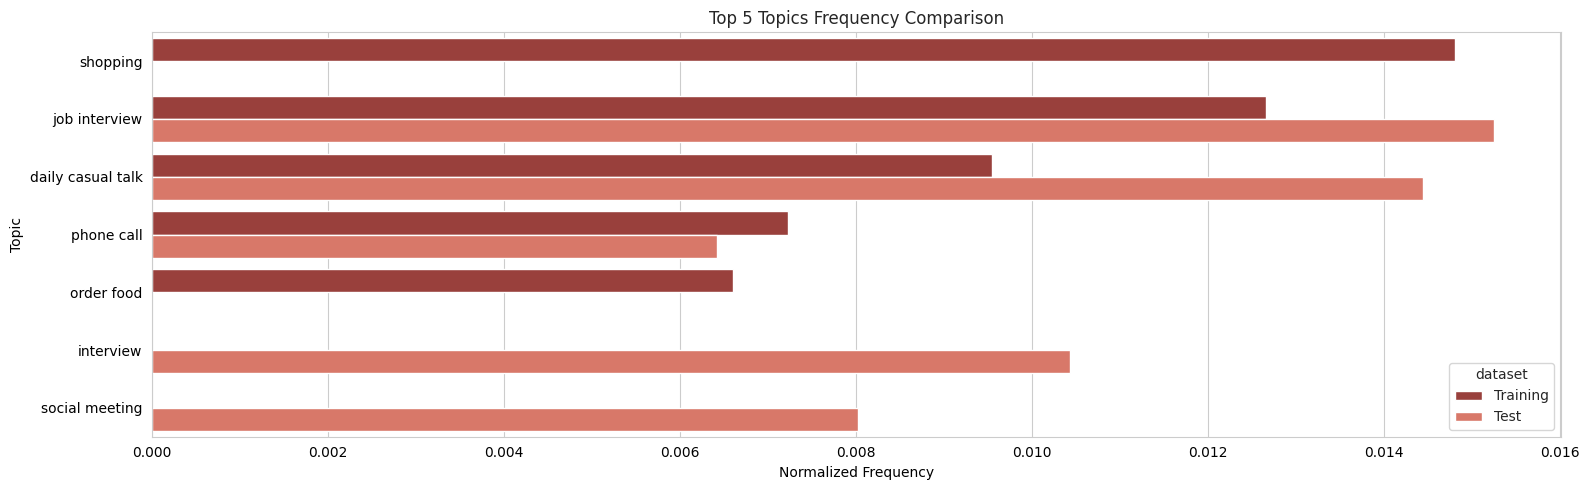

In [10]:
visualize_train_test_category_splits(train_df, test_df, top_x=5, normalize=True)

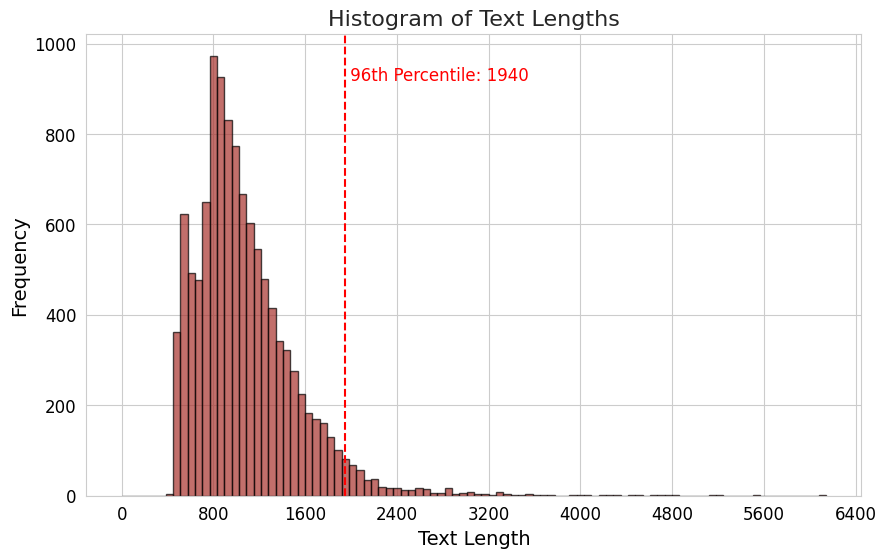

In [11]:
plot_text_length_histogram(train_df, percentile = 96)

## Load source model/tokenizer

In [12]:
%%time
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Quantization config
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

# loading the model with quantization config
model = AutoModelForCausalLM.from_pretrained(
    source_hf_model_name,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto",
    token = hf_token,
)

model.config.use_cache = True  #surpress the download and use cache. # apparently needed because of https://github.com/huggingface/transformers/pull/24906
model.config.pretraining_tp = 1  #disable tensor parallelism
#print(model)

tokenizer = AutoTokenizer.from_pretrained(
    source_hf_model_name, 
    trust_remote_code=True, 
    return_token_type_ids=False,
    token = hf_token,
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/app/venv/lib/python3.10/site-packages/transformers/utils/hub.py:374: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


CPU times: user 5.93 s, sys: 31.7 s, total: 37.6 s
Wall time: 3min 21s


In [13]:
%%time
import trl
from peft import LoraConfig, get_peft_model
from peft import prepare_model_for_kbit_training
from trl import SFTTrainer
from transformers import EarlyStoppingCallback
import transformers



# Parameter efficient finetuning for LoRA configuration

peft_config = LoraConfig(
    lora_alpha=lora_alpha,
    lora_dropout=lora_dropout,
    #target_modules=[ "q_proj","v_proj",],  # we will only create adopters for q, v metrices of attention module
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj","gate_proj"],
    r=lora_r,
    bias="none",
    task_type="CAUSAL_LM",
)


training_arguments = transformers.TrainingArguments(
    output_dir=project_dir,
    #load_from_checkpoint=str,
    seed = seed,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim="paged_adamw_8bit",
    learning_rate= learning_rate,
    #lr_scheduler_type="linear",
    save_strategy="steps",
    logging_steps=logging_steps,
    num_train_epochs=epochs,
    max_steps=0,
    fp16=True,
    push_to_hub=False,
    evaluation_strategy="steps",  # Add this line
    eval_steps=logging_steps,  # Add this line
    metric_for_best_model="loss",
    greater_is_better=False,
    load_best_model_at_end=True,
)
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    peft_config=peft_config,  # passing peft config
    dataset_text_field="text",  # mentioned the required column
    args=training_arguments,  # training agruments
    tokenizer=tokenizer,  # tokenizer
    packing=False,
    max_seq_length=max_training_sample_length,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)],
)

Map:   0%|          | 0/11214 [00:00<?, ? examples/s]

Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

CPU times: user 28.4 s, sys: 1.77 s, total: 30.2 s
Wall time: 21.1 s


## Train lora

In [ ]:
%%time
if False:
    trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss,Validation Loss
25,1.209800,1.187238
50,1.138500,1.176472
75,1.110000,1.170948
100,1.124200,1.163659
125,1.098700,1.159371
150,1.099800,1.155005
175,1.107700,1.150710
200,1.070700,1.145581
225,1.077100,1.140861
250,1.078300,1.136599


In [22]:
print("done!")

done!

## save peft model

In [13]:
%%time
import os
trainer.model.save_pretrained(project_path)

NameError: name 'trainer' is not defined

In [15]:
project_dir

'chat_summarizer'

In [17]:
!ls -lhatrs ./$project_path/

total 375M
   0 drwxr-xr-x 1 root root 4.0K Nov  5 12:28 .
   0 drwxr-xr-x 1 root root 4.0K Nov  5 17:35 ..
4.0K -rw-r--r-- 1 root root 1.3K Nov  5 18:26 README.md
375M -rw-r--r-- 1 root root 375M Nov  5 18:26 adapter_model.bin
   0 -rw-r--r-- 1 root root  493 Nov  5 18:26 adapter_config.json


In [18]:
!ls -latrsh ./$project_path

total 375M
   0 drwxr-xr-x 1 root root 4.0K Nov  5 12:28 .
   0 drwxr-xr-x 1 root root 4.0K Nov  5 17:35 ..
4.0K -rw-r--r-- 1 root root 1.3K Nov  5 18:26 README.md
375M -rw-r--r-- 1 root root 375M Nov  5 18:26 adapter_model.bin
   0 -rw-r--r-- 1 root root  493 Nov  5 18:26 adapter_config.json


In [19]:
!cat ./$project_path/README.md


---
library_name: peft
---
## Training procedure


The following `bitsandbytes` quantization config was used during training:
- quant_method: bitsandbytes
- load_in_8bit: False
- load_in_4bit: True
- llm_int8_threshold: 6.0
- llm_int8_skip_modules: None
- llm_int8_enable_fp32_cpu_offload: False
- llm_int8_has_fp16_weight: False
- bnb_4bit_quant_type: nf4
- bnb_4bit_use_double_quant: False
- bnb_4bit_compute_dtype: float16

The following `bitsandbytes` quantization config was used during training:
- quant_method: bitsandbytes
- load_in_8bit: False
- load_in_4bit: True
- llm_int8_threshold: 6.0
- llm_int8_skip_modules: None
- llm_int8_enable_fp32_cpu_offload: False
- llm_int8_has_fp16_weight: False
- bnb_4bit_quant_type: nf4
- bnb_4bit_use_double_quant: False
- bnb_4bit_compute_dtype: float16

The following `bitsandbytes` quantization config was used during training:
- quant_method: bitsandbytes
- load_in_8bit: False
- load_in_4bit: True
- llm_int8_threshold: 6.0
- llm_int8_skip_modules:

## Load peft model from checkpoint on disk

In [20]:
from peft import LoraConfig, get_peft_model
lora_config = LoraConfig.from_pretrained(project_path)
lmodel = get_peft_model(model, lora_config)

NameError: name 'model' is not defined

In [83]:
text = test_df['text'][500]
print(text)
result = generate(text, lmodel, max_new_tokens=64, temp=0.1)
#del lmodel

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Well, Charles, I must say that your shop is pretty remarkable. Do people send the fax messages abroad, 
or is it just to this country?
#Person2#: It's surprising because when I started, I thought I'd be sending things to London and maybe Birmingham 
but, in fact, a high percentage of it is sent abroad, because it's immediate and speedy.
#Person1#: And how much would it cost, for example, if I wanted to send a fax to the United States?
#Person2#: Well, a fax to the United States would cost you five pounds for a page. And when you think that in 
England by the Royal Mail, it would cost you twelve pounds to send a page by special delivery, it's actually a good
value.
#Person1#: Ok. What about your hours? How long do you have to spend actually in the shop?
#Person2#: Well, the shop is open from eight in the morning until six at night, six days a week, and then a sort of
fairly flexible morning on a Sunday. Urn, and of those hours, I'm in it quite a lot.
#Person1#: And did you enjoy it?
#Person2#: Yes, overall I enjoy it. Running a business by yourself is hard work and you never quite like every 
aspect all the time. 95% of the customers I love. Uh, 2% I really, you know, I'm not too bothered about. And 3% I 
positively hate.
#Person1#: What, what's the problem with those?
#Person2#: Um, it's hard to categorize really. I find people who are just totally rude, um, unnecessary, and I 
don't really need their business and I suppose they form the volume of the people that I don't like but it's a very
small percentage.
### Response :

The above conversation between two persons named Person1 and Person2 took place in an office where both were working as employees. The first person was interested in knowing more details regarding the services provided by his colleague’s company which he had heard recently. He asked him whether there were any other countries apart from UK whose citizens


In [92]:
#del  model

In [85]:
result

'The above conversation between two persons named Person1 and Person2 took place in an office where both were working as employees. The first person was interested in knowing more details regarding the services provided by his colleague’s company which he had heard recently. He asked him whether there were any other countries apart from UK whose citizens'

## load the orignal model for reference (i think?)

In [11]:
project_path

'chat_summarizer/best_checkpoint'

In [12]:
%%time
from peft import AutoPeftModelForCausalLM
tokenizer = AutoTokenizer.from_pretrained(
    source_hf_model_name, 
    trust_remote_code=True, 
    return_token_type_ids=False,
    token = hf_token,
)
persisted_model = AutoPeftModelForCausalLM.from_pretrained(
    project_path,
    low_cpu_mem_usage=True,
    return_dict=True,
    torch_dtype=torch.float16,
    device_map=device,
    token=hf_token,
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt



In [26]:
text = test_df['text'][500]
print(text)
result = generate(text, persisted_model, max_new_tokens=64, temp=0.1)
#del persisted_model

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: What about driving to Shanghai?
#Person2#: Driving? No way, it's too far.
#Person1#: I just thought it would be an interesting way to see lots of places. How long will it take?
#Person2#: Too long, and you do not have much time.
#Person1#: What a pity.
### Response :

Driving is no longer considered as one of the best ways for travelers who want to explore China in depth because there are many other options available nowadays such as taking trains or planes which can save both money & time compared with cars especially when going from Beijing (the capital city) all over


In [28]:
result

'Driving is no longer considered as one of the best ways for travelers who want to explore China in depth because there are many other options available nowadays such as taking trains or planes which can save both money & time compared with cars especially when going from Beijing (the capital city) all over'

## Merge the lora and original model

In [12]:
merged_dir
!ls -lathrs $merged_dir

total 13G
   0 -rw-r--r-- 1 root root   42 Nov  5 15:59 added_tokens.json
   0 drwxr-xr-x 1 root root 4.0K Nov  5 15:59 .
4.0K -rw-r--r-- 1 root root  656 Nov  5 21:28 config.json
   0 -rw-r--r-- 1 root root  183 Nov  5 21:28 generation_config.json
9.3G -rw-r--r-- 1 root root 9.3G Nov  5 21:35 model-00001-of-00002.safetensors
3.3G -rw-r--r-- 1 root root 3.3G Nov  5 21:35 model-00002-of-00002.safetensors
 24K -rw-r--r-- 1 root root  24K Nov  5 21:35 model.safetensors.index.json
4.0K -rw-r--r-- 1 root root  900 Nov  5 21:35 tokenizer_config.json
   0 -rw-r--r-- 1 root root  414 Nov  5 21:35 special_tokens_map.json
492K -rw-r--r-- 1 root root 489K Nov  5 21:35 tokenizer.model
1.8M -rw-r--r-- 1 root root 1.8M Nov  5 21:35 tokenizer.json
   0 drwxr-xr-x 1 root root 4.0K Nov  5 22:22 ..


In [30]:
%%time


merged_model = persisted_model.merge_and_unload(progressbar=True)

merged_model.save_pretrained(merged_dir, safe_serialization=True)
tokenizer.save_pretrained(merged_dir)

del persisted_model

Unloading and merging model: 100%|██████████| 454/454 [00:18<00:00, 25.05it/s]


CPU times: user 6min 51s, sys: 5.47 s, total: 6min 57s
Wall time: 7min 4s


## Load merged model from disk

In [12]:
tokenizer = AutoTokenizer.from_pretrained(merged_dir)
merged_model_from_disk = AutoModelForCausalLM.from_pretrained( merged_dir, device_map=device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [15]:
text = test_df['text'][1]
print(text,"\n","="*30)
result = generate(text, merged_model_from_disk,max_new_tokens=64, temp = 0.01)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :
 
 ==============================

The meeting will start at four in the afternoon according to Mr. Ewing who has requested for everyone to arrive early so they do not miss out anything important during the event. He also mentioned that some members from their East York Branch Office would attend this meeting which means it’s very crucial since these individuals have never


In [21]:
#del merged_model_from_disk

## Quantize it

In [35]:
%%time
from transformers import GPTQConfig

quantization_config = GPTQConfig(
    bits=4,
    dataset=["c4"],
    desc_act=False,
)

quant_model = AutoModelForCausalLM.from_pretrained(
    merged_dir, 
    quantization_config=quantization_config, 
    device_map=device
)
tokenizer = AutoTokenizer.from_pretrained(merged_dir)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Quantizing model.layers blocks :   0%|          | 0/32 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Quantizing layers inside the block:   0%|          | 0/7 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


CPU times: user 1h 40min 47s, sys: 15min 18s, total: 1h 56min 6s
Wall time: 1h 35min 50s


## Save quantized model to disk

In [36]:
%%time

quant_path = os.path.join(project_dir, quantization_dir)
print(f"saving to {quant_path}")

# Save the quantized model
quant_model.save_pretrained(quant_path, safe_serialization=True)
tokenizer.save_pretrained(quant_path)
#del persisted_model

saving to chat_summarizer/quantized

CPU times: user 1.33 s, sys: 827 ms, total: 2.15 s
Wall time: 4.56 s


('chat_summarizer/quantized/tokenizer_config.json',
 'chat_summarizer/quantized/special_tokens_map.json',
 'chat_summarizer/quantized/tokenizer.model',
 'chat_summarizer/quantized/added_tokens.json',
 'chat_summarizer/quantized/tokenizer.json')

In [17]:
!ls -latrsh $quant_path

total 164K
   0 drwxr-xr-x 1 root root 4.0K Nov  4 12:02 my_test_1
   0 drwxrwxrwx 1 root root 4.0K Nov  5 00:04 ..
   0 drwxr-xr-x 1 root root 4.0K Nov  5 00:05 .git
   0 drwxr-xr-x 1 root root 4.0K Nov  5 00:06 .ipynb_checkpoints
   0 drwxr-xr-x 1 root root 4.0K Nov  5 15:59 merged_model
   0 drwxr-xr-x 1 root root 4.0K Nov  5 17:35 chat_summarizer
   0 drwxr-xr-x 1 root root 4.0K Nov  5 20:43 wandb
164K -rw-r--r-- 1 root root 162K Nov  5 20:56 lora_gptq_trainer.ipynb
   0 drwxr-xr-x 1 root root 4.0K Nov  5 20:56 .


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Load quantized model from disk

In [12]:
from transformers import AutoModelForCausalLM, AutoTokenizer

print(quant_path)
quant_model_from_disk = AutoModelForCausalLM.from_pretrained( quant_path, device_map=device)
tokenizer = AutoTokenizer.from_pretrained(quant_path)

chat_summarizer/quantized

In [13]:
#xxxx
text = test_df['text'][1]
print(text,"\n","="*30)
result = generate(text, quant_model_from_disk,max_new_tokens=64, temp = 0.1)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: Mister Ewing said we should show up at the conference center at 4:00 o'clock, right?
#Person2#: Yes, he especially asked us not to be late. Some of the people from our east york branch office are 
coming, and he wants to make a good impression on them. How are you getting there?
#Person1#: I was thinking of taking my car, but I think I'm just going to take the underground, because there is 
construction on the highway. What about you?
#Person2#: I'll be taking the underground as well. Why don't we go together? I've been to the conference center 
only once, and I'm not sure if I can find my way around there.
### Response :
 
 ==============================

I am planning to attend this meeting with Mr. Ewing in person. He has specifically requested all employees to reach the venue by 5 pm sharp so that everyone gets an opportunity to interact with each other before starting work for tomorrow. We will also have some colleagues visiting us who belong to East York


In [29]:
result

'I think this is one of those times when we should be thankful for what we already have and stop trying to get more stuff. We don’t need any new clothes or accessories; our wardrobes are filled up as they can possibly be without looking like we just stepped out of some thrift store'

## Push model to HuggingFace hub

In [48]:
%%time

tokenizer.push_to_hub(destination_hf_model_name, token=hf_token)
merged_model.push_to_hub(destination_hf_model_name, token = hf_token)

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

CPU times: user 53 s, sys: 19.8 s, total: 1min 12s
Wall time: 7min 52s


CommitInfo(commit_url='https://huggingface.co/andersonjas/llama2-7b-dialogsum-qlora-gptq/commit/081f1e4d9b1696c422dc8369056d626edda4b934', commit_message='Upload LlamaForCausalLM', commit_description='', oid='081f1e4d9b1696c422dc8369056d626edda4b934', pr_url=None, pr_revision=None, pr_num=None)

In [11]:
%%time
# %%
from transformers import GPTQConfig

quantization_config = GPTQConfig(
    bits=4,
    dataset=["c4"],
    desc_act=False,
)
quantization_config_loading = GPTQConfig(bits=4, disable_exllama=True)
from_disk_quant_model = AutoModelForCausalLM.from_pretrained(
    destination_hf_model_name, 
    #quantization_config=quantization_config_loading, 
    device_map=device,
)
tokenizer = AutoTokenizer.from_pretrained(destination_hf_model_name)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 23.4 s, sys: 14.5 s, total: 38 s
Wall time: 30.9 s


In [ ]:
text = test_df['text'][500]
print(text)
result = generate(text, from_disk_quant_model, max_new_tokens=64,temp=0.1)

### Instruction: 
Write a concise summary of the below input text.Ensure that responses covers the key points of the text.Only 
provide full sentence responses.
### Input: 
#Person1#: What do you say to eating out, Maggie?
#Person2#: Yeah, why not? We haven't been out for dinner for quite a long time. A new French restaurant has just 
opened in our neighborhood. We can go there.
#Person1#: Do we need to book a table in advance?
#Person2#: No need for that. It's not usually busy on weekdays.
#Person1#: What time shall we go?
#Person2#: Why not now? I'm hungry.
### Response :

I think it is better if we eat at home today because my mother will be back from work soon and she needs help with cooking. Besides, I have some assignments due tomorrow so I don’t want to spend too much money 

In [23]:
result

'I think this is one of those times when we should be thankful for what we already have and stop trying to get more stuff. We don’t need any new clothes or accessories; our wardrobes are filled up as they can possibly be without looking like we just stepped out of some thrift store'